In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf


import os



from glob import glob
from PIL import Image as pil_image
from matplotlib.pyplot import imshow, imsave
from IPython.display import Image as Image

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.utils.np_utils import to_categorical
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD
from keras import regularizers, initializers
from keras.layers.advanced_activations import LeakyReLU, ReLU, Softmax
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda
from keras.layers.merge import concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import *
from keras.utils import plot_model
from keras.models import load_model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.nasnet import NASNetLarge
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
#import the data 
dataframe = pd.read_csv('sample2.csv')

In [50]:
dataframe.head(9)

,Unnamed: 0,image,MEL,NV,CL,UNK
0,2,ISIC_0014927_downsampledrot90,0,1,0,0
1,5,ISIC_0015981_downsampledcntrst,0,1,0,0
2,7,ISIC_0025827cntrst,0,1,0,0
3,10,ISIC_0024380bright,0,1,0,0
4,20,ISIC_0011323rot90,0,1,0,0
5,26,ISIC_0015021_downsampledrot90,0,1,0,0
6,32,ISIC_0014787_downsampledbright,0,1,0,0
7,38,ISIC_0024478bright,0,1,0,0
8,39,ISIC_0012538_downsampledcntrst,0,1,0,0


In [51]:
df= dataframe.iloc[: , 1:]

In [52]:
df.head()

,image,MEL,NV,CL,UNK
0,ISIC_0014927_downsampledrot90,0,1,0,0
1,ISIC_0015981_downsampledcntrst,0,1,0,0
2,ISIC_0025827cntrst,0,1,0,0
3,ISIC_0024380bright,0,1,0,0
4,ISIC_0011323rot90,0,1,0,0


# Data Processing

In [53]:
df['type']=df['MEL']+1

In [54]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join('', '*', '*.jpg'))}
df['path'] = df['image'].map(image_path.get)


In [55]:
df=df.drop(columns=['NV', 'CL','UNK','MEL'])

In [56]:
image_example = np.asarray(pil_image.open(df['path'][0]))

In [57]:
df['im'] = df['path'].map(lambda x: np.asarray(pil_image.open(x).resize((120,90))))

In [58]:
df.head()

,image,type,path,im
0,ISIC_0014927_downsampledrot90,1,images_sample\ISIC_0014927_downsampledrot90.jpg,"[[[232, 220, 224], [228, 217, 219], [224, 213,..."
1,ISIC_0015981_downsampledcntrst,1,images_sample\ISIC_0015981_downsampledcntrst.jpg,"[[[152, 107, 91], [144, 108, 84], [143, 97, 68..."
2,ISIC_0025827cntrst,1,images_sample\ISIC_0025827cntrst.jpg,"[[[237, 164, 192], [240, 164, 193], [239, 158,..."
3,ISIC_0024380bright,1,images_sample\ISIC_0024380bright.jpg,"[[[247, 205, 235], [251, 209, 237], [254, 213,..."
4,ISIC_0011323rot90,1,images_sample\ISIC_0011323rot90.jpg,"[[[165, 156, 155], [166, 159, 157], [165, 161,..."


In [59]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'unk':'unknown'
   
}

lesion_classes_dict = {
    0:'unk',
    1:'nv',
    2:'mel'
    
   
}

df['cell_type'] = df['type'].map(lesion_classes_dict)

In [60]:
df

,image,type,path,im,cell_type
0,ISIC_0014927_downsampledrot90,1,images_sample\ISIC_0014927_downsampledrot90.jpg,"[[[232, 220, 224], [228, 217, 219], [224, 213,...",nv
1,ISIC_0015981_downsampledcntrst,1,images_sample\ISIC_0015981_downsampledcntrst.jpg,"[[[152, 107, 91], [144, 108, 84], [143, 97, 68...",nv
2,ISIC_0025827cntrst,1,images_sample\ISIC_0025827cntrst.jpg,"[[[237, 164, 192], [240, 164, 193], [239, 158,...",nv
3,ISIC_0024380bright,1,images_sample\ISIC_0024380bright.jpg,"[[[247, 205, 235], [251, 209, 237], [254, 213,...",nv
4,ISIC_0011323rot90,1,images_sample\ISIC_0011323rot90.jpg,"[[[165, 156, 155], [166, 159, 157], [165, 161,...",nv
...,...,...,...,...,...
1995,ISIC_0032095cntrst,2,images_sample\ISIC_0032095cntrst.jpg,"[[[176, 129, 141], [179, 132, 144], [181, 134,...",mel
1996,ISIC_0061629bright,2,images_sample\ISIC_0061629bright.jpg,"[[[104, 104, 104], [104, 104, 104], [104, 104,...",mel
1997,ISIC_0056269,2,images_sample\ISIC_0056269.jpg,"[[[192, 170, 167], [194, 170, 167], [195, 171,...",mel
1998,ISIC_0060648bright,2,images_sample\ISIC_0060648bright.jpg,"[[[219, 223, 226], [234, 235, 237], [246, 247,...",mel


## Data Splitting

In [61]:
features = df.drop(['type'],axis=1)
target = df['type']

In [62]:
X_TRAIN, X_TEST, Y_TRAIN, Y_TEST = train_test_split(features,target,test_size=0.01)

In [63]:
print(Y_TEST)

311     1
976     1
58      1
1533    2
1467    2
673     1
960     1
1420    2
1992    2
1052    2
1414    2
258     1
1131    2
770     1
1699    2
56      1
882     1
1321    2
1295    2
1857    2
Name: type, dtype: int64


In [64]:
x_train = np.asarray(X_TRAIN['im'].tolist())
x_test = np.asarray(X_TEST['im'].tolist())

In [65]:
train_mean = x_train.mean()
train_std = x_train.std()
test_mean = x_test.mean()
test_std = x_test.std()

## Using Image Standardization

In [66]:
x_train = (x_train-train_mean) / train_std
x_test = (x_test-test_mean) / test_std

In [67]:
y_train = to_categorical(Y_TRAIN,num_classes=3)
y_test = to_categorical(Y_TEST,num_classes=3)

In [68]:
print(y_test)

[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [69]:
print(y_train.shape)
print(y_test.shape)

(1980, 3)
(20, 3)


In [70]:
X_train,X_val, Y_train,Y_val = train_test_split(x_train,y_train,test_size=0.15)

In [71]:
X_train  = X_train.reshape(X_train.shape[0],90,120,3)
x_test  = x_test.reshape(x_test.shape[0],90,120,3)
X_val  = X_val.reshape(X_val.shape[0],90,120,3)

## Train Models

### 1. Simple Sequential Network


In [40]:
input_shape = (90, 120, 3)
num_classes = 3

model = Sequential()

model.add(Conv2D(32,kernel_size=(3, 3),activation='relu',name="conv1", input_shape=input_shape)) #88,118
model.add(BatchNormalization(name="Norm1"))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',name="Conv2")) #86,116
model.add(BatchNormalization(name="Norm2"))
model.add(Conv2D(64,kernel_size=(3, 3), activation='relu',name="Conv3")) #84,114
model.add(BatchNormalization(name="Norm3"))
model.add(MaxPooling2D(pool_size = (2, 2))) # 42,57
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',name="conv4")) #40,55
model.add(BatchNormalization(name="Norm4"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv5")) #38,53
model.add(BatchNormalization(name="Norm5"))
model.add(Conv2D(128, (3, 3), activation='relu',name="conv6")) #36,51
model.add(BatchNormalization(name="Norm6"))
model.add(MaxPooling2D(pool_size=(2, 2))) #18,25
model.add(Dropout(0.20))

model.add(Conv2D(128, (3, 3), activation='relu',name="conv7")) #16,23
model.add(BatchNormalization(name="Norm7"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv8")) #14,21
model.add(BatchNormalization(name="Norm8"))
model.add(Conv2D(256, (3, 3), activation='relu',name="conv9")) #12,19
model.add(BatchNormalization(name="Norm9"))
model.add(MaxPooling2D(pool_size=(2, 2))) #6,9
model.add(Dropout(0.20))

model.add(Conv2D(3,(1,1),name="conv10",activation="relu")) #6,9
model.add(BatchNormalization(name="Norm10"))
model.add(Conv2D(3,kernel_size=(6,9),name="conv11"))
model.add(Flatten())
model.add(Activation('softmax'))

In [41]:
model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [42]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.0001, 
                                            min_lr=0.000001)

## Saving Checkpoint


In [84]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [46]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)


# Fit the model
epochs = 20
batch_size = 10
model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction,cp_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
168/168 [==============================] - ETA: 0s - loss: 0.9151 - accuracy: 0.5643
Epoch 00001: saving model to training_1\cp.ckpt
168/168 [==============================] - 379s 2s/step - loss: 0.9151 - accuracy: 0.5643 - val_loss: 1.1282 - val_accuracy: 0.5152
Epoch 2/20
168/168 [==============================] - ETA: 0s - loss: 0.6983 - accuracy: 0.6533
Epoch 00002: saving model to training_1\cp.ckpt
168/168 [==============================] - 394s 2s/step - loss: 0.6983 - accuracy: 0.6533 - val_loss: 0.6611 - val_accuracy: 0.6734
Epoch 3/20
168/168 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.6820
Epoch 00003: saving model to training_1\cp.ckpt
168/168 [==============================] - 374s 2s/step - loss: 0.6306 - accuracy: 0.6820 - val_loss: 0.6196 - val_accuracy: 0.6902
Epoch 4/20
168/168 [==============================] - ETA: 0s - loss: 0.5869 - accuracy: 0.7005


### Testing with a new image of a lesion 

Original Shape of image is :  (428, 650, 3)


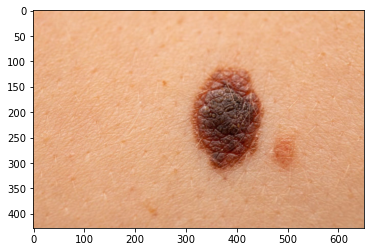

In [67]:
import urllib
url="https://2rdnmg1qbg403gumla1v9i2h-wpengine.netdna-ssl.com/wp-content/uploads/sites/3/2021/04/moleSkinCancer-1150885505-770x533-1-650x428.jpg"
urllib.request.urlretrieve(url,'test.jpg')
test_image = np.asarray(pil_image.open('test.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [68]:
resized_image = np.asarray(pil_image.open('test.jpg').resize((120,90)))
image_array = np.asarray(resized_image.tolist())
test_image = image_array.reshape(1,90,120,3)

In [69]:
prediction_class = model.predict_classes(test_image)
print(prediction_class)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[2]


In [70]:
lesion_classes_dict[prediction_class[0]]

'mel'

Original Shape of image is :  (299, 299, 3)


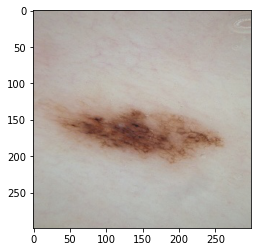

In [98]:

test_image = np.asarray(pil_image.open('images_sample\ISIC_0011323rot90.jpg'))
print('Original Shape of image is : ',test_image.shape)
plt.imshow(test_image)

In [99]:
resized_im= np.asarray(pil_image.open('test.jpg').resize((120,90)))
im_array = np.asarray(resized_im.tolist())
test_im= im_array.reshape(1,90,120,3)

In [100]:
prediction_class = model.predict_classes(test_im)
print(prediction_class)

[2]


In [101]:
lesion_classes_dict[prediction_class[0]]

'mel'

In [48]:
os.listdir(checkpoint_dir)

['checkpoint', 'cp.ckpt.data-00000-of-00001', 'cp.ckpt.index']

### 2-VGG16

In [39]:
def vgg16():
    
    height = 90
    width  = 120
    vgg = VGG16(include_top=False, input_shape=(height, width, 3))
    flat1 = Flatten()(vgg.layers[-1].output)
    class1 = Dense(1024, kernel_regularizer=regularizers.l2(0.001), activation='relu')(flat1)
    class1 = Dropout(0.5)(class1)
    output = Dense(3, activation='softmax')(class1)
    model = Model(inputs=vgg.inputs, outputs=output)

    model.compile(optimizer=SGD(learning_rate=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [40]:
model=vgg16()

In [41]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.0001, 
                                            min_lr=0.000001)
datagen = ImageDataGenerator(
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1 # Randomly zoom image 
)


# Fit the model
epochs = 5
batch_size = 10
model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/5
168/168 [==============================] - 472s 3s/step - loss: 2.1944 - accuracy: 0.6635 - val_loss: 2.0161 - val_accuracy: 0.7407
Epoch 2/5
168/168 [==============================] - 437s 3s/step - loss: 2.0222 - accuracy: 0.7681 - val_loss: 1.9731 - val_accuracy: 0.7912
Epoch 3/5
168/168 [==============================] - 447s 3s/step - loss: 1.9460 - accuracy: 0.8063 - val_loss: 1.9581 - val_accuracy: 0.7912
Epoch 4/5
168/168 [==============================] - 477s 3s/step - loss: 1.9047 - accuracy: 0.8249 - val_loss: 1.9550 - val_accuracy: 0.8081
Epoch 5/5
168/168 [==============================] - 476s 3s/step - loss: 1.8682 - accuracy: 0.8548 - val_loss: 1.9382 - val_accuracy: 0.8249


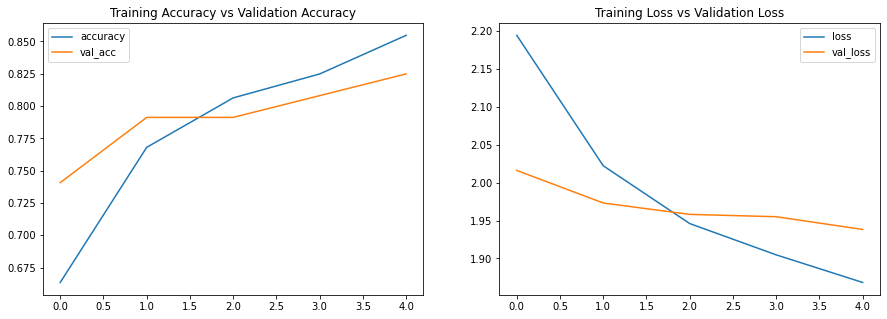

In [42]:
def plot_(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f, [ax1, ax2] = plt.subplots(1,2, figsize=(15, 5))
    ax1.plot(range(len(acc)), acc, label="accuracy")
    ax1.plot(range(len(acc)), val_acc, label="val_acc")
    ax1.set_title("Training Accuracy vs Validation Accuracy")
    ax1.legend()

    ax2.plot(range(len(loss)), loss, label="loss")
    ax2.plot(range(len(loss)), val_loss, label="val_loss")
    ax2.set_title("Training Loss vs Validation Loss")
    ax2.legend()
    
    
plot_(model.history)

Original Shape of image is :  (194, 260, 3)


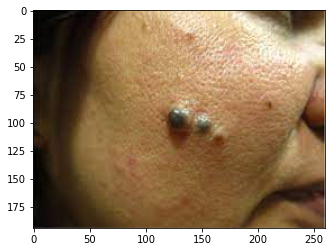

In [43]:
url="https://europepmc.org/articles/PMC3965271/bin/ccid-7-089Fig3.jpg"
test_image2 = np.asarray(pil_image.open('test2.jpg'))
print('Original Shape of image is : ',test_image2.shape)
plt.imshow(test_image2)

In [72]:
resized_image2 = np.asarray(pil_image.open('test2.jpg').resize((120,90)))
image_array2 = np.asarray(resized_image2.tolist())
test_image2 = image_array2.reshape(1,90,120,3)

In [75]:
prediction_class = model.predict(test_image2)
prediction_class = np.argmax(prediction_class,axis=1)

In [76]:
print(prediction_class)

[2]
